In [231]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import datasets
import matplotlib.pyplot as plt
import lightning.pytorch as pl
import math
import torch.nn.functional as F
from tqdm import tqdm

In [232]:
TRAIN_SIZE = 0.8
TEST_SIZE = 1 - TRAIN_SIZE
PATCH_SIZE = 16
BATCH_SIZE = 32
IMG_SIZE = 256

D_MODEL = 768
NUM_HEADS = 8
NUM_LAYERS = 6
DROPOUT_P = 0.1
IN_CHANNELS = 3
PATCH_SIZE = 16
NUM_CLASSES = 257
EPOCHS = 10

Files already downloaded and verified


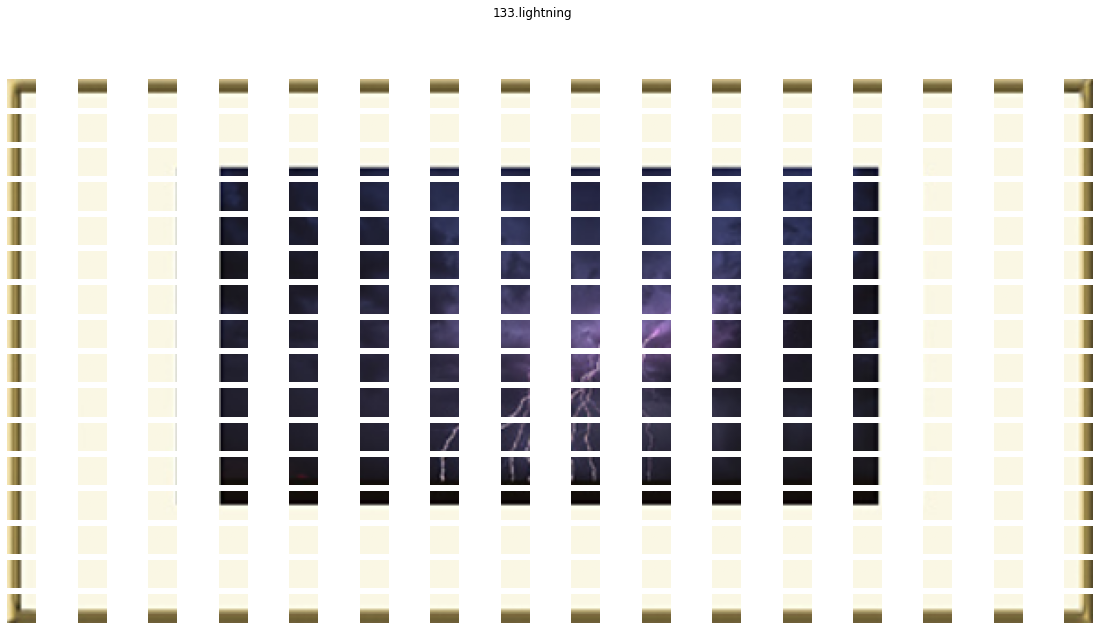

In [233]:
class PatchCollate:

    def __init__(self, kernel, stride):
        self.kernel, self.stride = kernel, stride

    def __call__(self, x):
        x, labels = torch.utils.data.default_collate(x)
        b, c, _, _ = x.shape
        windows = x.unfold(2, self.kernel, self.stride).unfold(3, self.kernel, self.stride).permute(0, 2, 3, 1, 4, 5)
        return windows.reshape(b, -1, c, windows.shape[-2], windows.shape[-1]), labels
    

class ToRGB:

    def __init__(self):
        pass

    def __call__(self, img):
        if img.shape[0] == 1:
            return img.repeat(3, 1, 1)
        return img


def test_image(loader, idx_map):
    imgs, labels = next(iter(train_loader))
    output, output_label = imgs[0], idx_map[labels[0].item()]
    fig, ax = plt.subplots(nrows=16, ncols=16, figsize=(20, 10))
    ax = ax.flatten()
    for patch, axis in zip(output, ax):
        axis.imshow(patch.permute(1, 2, 0))
        axis.axis(False)
    fig.suptitle(output_label)
    plt.show()


T = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    ToRGB()
])
dataset = datasets.Caltech256("./dataset", download=True, transform=T)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [TRAIN_SIZE, TEST_SIZE])
class_to_idx = {c: i for i, c in enumerate(dataset.categories)}
idx_to_class = {value: key for key, value in class_to_idx.items()}

patch_collate_fn = PatchCollate(PATCH_SIZE, PATCH_SIZE)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, collate_fn=patch_collate_fn)
test_loader = DataLoader(test_dataset, BATCH_SIZE * 2, collate_fn=patch_collate_fn)

test_image(train_loader, idx_to_class)

In [234]:
class ViTLinearProjection(nn.Module):

    def __init__(self, in_channels, patch_size, d_model):
        super(ViTLinearProjection, self).__init__()
        self.linear = nn.Linear(in_channels * patch_size * patch_size, d_model)

    def forward(self, x):
        x = x.view(x.shape[0], x.shape[1], -1)
        return self.linear(x)

class FeedForward(nn.Module):

    def __init__(self, input_dim):
        super(FeedForward, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, input_dim * 4),
            nn.GELU(),
            nn.Linear(input_dim * 4, input_dim)
        )

    def forward(self, x):
        return self.layer(x)


class ViTEncoderBlock(nn.Module):

    def __init__(self, d_model, num_heads, p=0.1):
        super(ViTEncoderBlock, self).__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.mha = nn.MultiheadAttention(d_model, num_heads, dropout=p)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = FeedForward(d_model)

    def forward(self, x):
        skip_x = x
        x = self.ln1(x)
        x, _ = self.mha(x, x, x)
        x = x + skip_x
        skip_x = x
        x = self.ln2(x)
        x = self.mlp(x)
        return x + skip_x
    

class ViT(nn.Module):

    def __init__(self, in_channels, patch_size, img_size, num_classes, d_model, num_heads, n_layers, p=0.1):
        super(ViT, self).__init__()
        self.in_proj = ViTLinearProjection(in_channels, patch_size, d_model)
        self.layers = nn.ModuleList([
            ViTEncoderBlock(d_model, num_heads, p) for _ in range(n_layers)
        ])
        self.out_proj = nn.Linear(d_model, num_classes)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.position_embedding = nn.Parameter(torch.randn(1, (img_size // patch_size) ** 2, d_model))

    def forward(self, x):
        x = self.in_proj(x)
        x = x + self.position_embedding
        x = torch.cat([self.cls_token.repeat(x.shape[0], 1, 1), x], dim=1)
        for layer in self.layers:
            x = layer(x)
        return self.out_proj(x[:, 0, :])

In [235]:
model = ViT(
    in_channels=IN_CHANNELS,
    patch_size=PATCH_SIZE,
    img_size=IMG_SIZE,
    num_classes=NUM_HEADS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    n_layers=NUM_LAYERS
)

In [236]:
class LitTrainingModule(pl.LightningModule):

    def __init__(self, model):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        yhat = self.model(imgs)
        loss = F.cross_entropy(yhat, labels)
        return loss
    
    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        yhat = self.model(imgs).argmax(dim=-1)
        return (yhat == labels).sum() / len(yhat)
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [238]:
trainer = pl.Trainer(max_epochs=EPOCHS)
training_model = LitTrainingModule(model)
trainer.fit(
    model = training_model,
    train_dataloaders=train_loader,
    val_dataloaders=test_loader,
    
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type | Params
-------------------------------
0 | model | ViT  | 43.3 M
-------------------------------
43.3 M    Trainable params
0         Non-trainable params
43.3 M    Total params
173.285   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

MisconfigurationException: `train_dataloader` must be implemented to be used with the Lightning Trainer